In [1]:
from indra.tools import assemble_corpus as ac
from indra.statements import Complex
from bioexp.util import pklload
from bioexp.curation.classifiers import BinaryRandomForest, LogLogisticRegression
from indra.ontology.bio import bio_ontology as bo
from indra.preassembler import Preassembler
from indra.belief.sklearn_scorer import SklearnScorer
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from indra.util import plot_formatting as pf

%matplotlib notebook

In [2]:
cd ..

/Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper


Load the preassembled statements:

In [3]:
indra_stmts = pklload('reading_only_asmb_preassembled')

Loading output/bioexp_reading_only_asmb_preassembled.pkl
Loaded output/bioexp_reading_only_asmb_preassembled.pkl in 51.0 seconds


Load the Biogrid statements:

In [4]:
from indra.sources.biogrid import BiogridProcessor
bp = BiogridProcessor()
bg_stmts_raw = bp.statements

INFO: [2020-12-04 11:14:34] indra.sources.biogrid - No data file specified, downloading from BioGrid at https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ALL-LATEST.tab3.zip
Processing BioGRID rows: 0it [00:00, ?it/s]INFO: [2020-12-04 11:18:32] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.4/bio_ontology.pkl
Processing BioGRID rows: 1974590it [03:50, 8548.16it/s] 


De-duplicate the Biogrid statements:

In [5]:
pa = Preassembler(bo, stmts=bg_stmts_raw)
bg_stmts_asmb = pa.combine_duplicates()

Filter both the INDRA-assembled and Biogrid statements to Complexes of human genes:

In [6]:
def filter_stmts(stmts):
    stmts = ac.filter_by_type(stmts, Complex)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    return stmts

# Filter to Complex of human genes
bg_stmts_filt = filter_stmts(bg_stmts_asmb)
indra_stmts_filt = filter_stmts(indra_stmts)

INFO: [2020-12-04 11:31:50] indra.tools.assemble_corpus - Filtering 870403 statements for type Complex...
INFO: [2020-12-04 11:31:51] indra.tools.assemble_corpus - 870403 statements after filter...
INFO: [2020-12-04 11:31:51] indra.tools.assemble_corpus - Filtering 870403 statements for ones containing genes only...
INFO: [2020-12-04 11:31:54] indra.tools.assemble_corpus - 823763 statements after filter...
INFO: [2020-12-04 11:31:55] indra.tools.assemble_corpus - Filtering 823763 statements for human genes only...
INFO: [2020-12-04 11:32:12] indra.tools.assemble_corpus - 474870 statements after filter...
INFO: [2020-12-04 11:32:12] indra.tools.assemble_corpus - Filtering 734208 statements for type Complex...
INFO: [2020-12-04 11:32:14] indra.tools.assemble_corpus - 166703 statements after filter...
INFO: [2020-12-04 11:32:14] indra.tools.assemble_corpus - Filtering 166703 statements for ones containing genes only...
INFO: [2020-12-04 11:32:16] indra.tools.assemble_corpus - 127300 state

Load the trained belief model and assign belief values to statements:

In [7]:
# Set beliefs for the statements
reader_list = ['reach', 'sparser', 'medscan', 'rlimsp', 'trips']
#model_path = 'output/trained_loglogreg.pkl'
model_path = 'output/trained_nobg_random_forest.pkl'
skls = SklearnScorer(model_path, reader_list)
skls.score_statements(indra_stmts_filt)

Get hashes of both sets of statements for comparison:

In [8]:
# Compare 
bg_hashes = set([s.get_hash(refresh=True) for s in bg_stmts_filt])
indra_hashes = set([s.get_hash(refresh=True) for s in indra_stmts_filt])

Build a dictionary of text-mined statements by hash so we can get them back from the hashes:

In [9]:
stmts_by_hash = {s.get_hash(refresh=True): s for s in indra_stmts_filt}

Stratify statements by belief bins:

In [10]:
def stmts_in_bg_by_belief(indra_hashes, bg_hashes, bin_info):
    in_bg = np.zeros(len(bin_info))
    not_in_bg = np.zeros(len(bin_info))
    in_bg_stmts = {}
    not_in_bg_stmts = {}
    for i, (lbound, ubound, label) in enumerate(bin_info):
        stmts_by_belief = [s for s in indra_stmts_filt
                           if s.belief > lbound and s.belief <= ubound]
        bin_hashes = set([s.get_hash(refresh=True) for s in stmts_by_belief])
        in_bg_hashes = bin_hashes.intersection(bg_hashes)
        not_in_bg_hashes = bin_hashes.difference(in_bg_hashes)

        in_bg[i] = len(in_bg_hashes)
        not_in_bg[i] = len(not_in_bg_hashes)
        in_bg_stmts[label] = [stmts_by_hash[h] for h in in_bg_hashes]
        not_in_bg_stmts[label] = [stmts_by_hash[h] for h in not_in_bg_hashes]
    return {'in_bg_cts': in_bg,
            'not_in_bg_cts': not_in_bg,
            'in_bg_stmts': in_bg_stmts,
            'not_in_bg_stmts': not_in_bg_stmts}

# Group indra stmts by belief bin and get counts and statements for the
# ones in Biogrid vs. not in Biogrid
bin_bounds = [0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0]
bin_info = [(bin_bounds[i], bin_bounds[i+1],
             f'{bin_bounds[i]}_{bin_bounds[i+1]}')
             for i in range(len(bin_bounds) - 1)]


in_bg_info = stmts_in_bg_by_belief(indra_hashes, bg_hashes, bin_info)


Plot belief distribution along with BG/not in BG status:

[0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99]


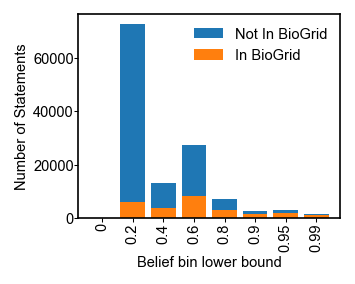

In [11]:
# Plot statement counts
def plot_in_bg(in_bg_dict, bin_info):
    index = np.array(range(len(bin_info)))
    plt.figure(figsize=(2.5, 2), dpi=150)
    plt.bar(index, in_bg_dict['not_in_bg_cts'],
            bottom=in_bg_dict['in_bg_cts'], label='Not In BioGrid')
    plt.bar(index, in_bg_dict['in_bg_cts'], label='In BioGrid')
    ax = plt.gca()
    ax.set_xticks(index)
    tls = [lb for lb, _, _ in bin_info]
    print(tls)
    ax.set_xticklabels(tls, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel('Number of Statements')
    plt.xlabel('Belief bin lower bound')
    pf.format_axis(ax)

    plt.legend(loc='upper right', fontsize=pf.fontsize, frameon=False)
    plt.subplots_adjust(bottom=0.2, left=0.2)

def plot_frac_in_bg(in_bg_dict, bin_info):
    fracs_in_bg = []
    lbs = []
    for i, (lb, _, _) in enumerate(bin_info):
        numer = in_bg_dict['in_bg_cts'][i]
        denom = in_bg_dict['not_in_bg_cts'][i] + numer
        # If there are no statements in this bin, skip it
        if denom == 0:
            continue
        lbs.append(lb)
        fracs_in_bg.append(numer / denom)

    # Plot statement percentages
    plt.figure(figsize=(2, 2), dpi=150)
    plt.plot(lbs, fracs_in_bg, marker='.')
    ax = plt.gca()
    ax.set_xticks(lbs)
    ax.set_xticklabels(lbs, rotation='vertical')
    pf.format_axis(ax)
    plt.ylabel('Frac. in BioGrid')
    plt.ylim(0, 1)
    plt.xlabel('Belief bin lower bound')
    plt.savefig('output/biogrid_stmt_percentages.pdf')
    plt.subplots_adjust(bottom=0.2, left=0.2)
    
plot_in_bg(in_bg_info, bin_info)


Plot the proportion of statements in each bin in Biogrid:

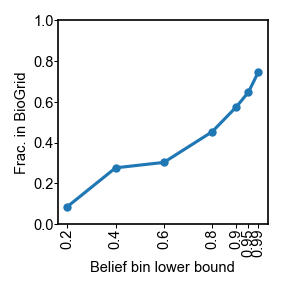

In [12]:
plot_frac_in_bg(in_bg_info, bin_info)

In [13]:
stmts20 = in_bg_info['not_in_bg_stmts']['0.2_0.4']

In [14]:
from collections import Counter
ev_ctr = Counter([ev.source_api for s in stmts20 for ev in s.evidence])
ev_ctr

Counter({'sparser': 63790, 'reach': 19347, 'isi': 1035})

In [15]:
import random
import pickle
random.seed(1)
samp20 = random.sample(stmts20, 100)
#with open('bioexp_biogrid_nobg_cplx_rf0204.pkl', 'wb') as f:
#    pickle.dump(samp20, f)

In [16]:
stmts90 = in_bg_info['not_in_bg_stmts']['0.9_0.95']
stmts95 = in_bg_info['not_in_bg_stmts']['0.95_0.99']
stmts99 = in_bg_info['not_in_bg_stmts']['0.99_1.0']

In [17]:
len(stmts90) + len(stmts95) + len(stmts99)

2554

In [18]:
len(stmts99)

353

In [ ]:
### random.seed(1)
samp99 = random.sample(stmts99, 100)
with open('bioexp_biogrid_nobg_cplx_rf09910.pkl', 'wb') as f:
    pickle.dump(samp99, f)

In [ ]:
foo = indra_hashes.difference(bg_hashes)
len(foo)

In [ ]:
from indra.assemblers.html import HtmlAssembler

In [ ]:
ha = HtmlAssembler(stmts99, db_rest_url='https://db.indra.bio')

In [ ]:
ha.save_model('indra_stmts_not_in_biogrid_belief99.html')

In [ ]:
HtmlAssembler?

In [33]:
raw = ac.filter_gene_list(bg_stmts_raw, ['BBC3', 'BCL2L1'], policy='all')
raw

INFO: [2020-12-04 11:38:55] indra.tools.assemble_corpus - Filtering 1131273 statements for ones containing "all" of: BBC3, BCL2L1...
INFO: [2020-12-04 11:38:59] indra.tools.assemble_corpus - 7 statements after filter...


[Complex(BBC3(), BCL2L1()),
 Complex(BCL2L1(), BBC3()),
 Complex(BBC3(), BCL2L1()),
 Complex(BCL2L1(), BCL2L1()),
 Complex(BCL2L1(), BBC3()),
 Complex(BCL2L1(), BBC3()),
 Complex(BCL2L1(), BBC3())]

In [34]:
ac.filter_genes_only(raw)

INFO: [2020-12-04 11:39:02] indra.tools.assemble_corpus - Filtering 7 statements for ones containing genes only...
INFO: [2020-12-04 11:39:02] indra.tools.assemble_corpus - 1 statements after filter...


[Complex(BCL2L1(), BCL2L1())]

In [35]:
raw[0]

Complex(BBC3(), BCL2L1())

In [36]:
raw[0].members[0].db_refs

{'EGID': '27113'}

In [28]:
foo = ac.filter_gene_list(bg_stmts_filt, ['BBC3', 'BCL2L1'], policy='all')

INFO: [2020-12-04 11:37:10] indra.tools.assemble_corpus - Filtering 474870 statements for ones containing "all" of: BBC3, BCL2L1...
INFO: [2020-12-04 11:37:12] indra.tools.assemble_corpus - 1 statements after filter...


In [29]:
foo

[Complex(BCL2L1(), BCL2L1())]

In [24]:
foo[0]

Complex(BBC3(), BCL2L1())

In [25]:
foo[0].members[0].db_refs

{'UP': 'Q96PG8', 'HGNC': '17868', 'TEXT': 'Puma'}

In [26]:
foo[0].get_hash()

-6926243157870405

In [27]:
_26 in bg_hashes

False